<a href="https://colab.research.google.com/github/binram077/GAN-with-mnist-fashion-dataset/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import tensorflow as tf
import keras
from matplotlib import pyplot as plt
import numpy as np
from keras import layers

In [18]:
(X_train,_),(_) = keras.datasets.fashion_mnist.load_data()
X_train = X_train/255.0
print(X_train.shape)

(60000, 28, 28)


In [19]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/images", label_mode=None, image_size=(64, 64), batch_size=128
)

Found 1 files belonging to 1 classes.


In [12]:
!unzip "/content/archive.zip"

Archive:  /content/archive.zip
warning [/content/archive.zip]:  346716902 extra bytes at beginning or within zipfile
  (attempting to process anyway)
file #1:  bad zipfile offset (local header sig):  346716902
  (attempting to re-compensate)
replace images/0_2000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: images/0_2000.jpg       
error: not enough memory for bomb detection
error: invalid zip file with overlapped components (possible zip bomb)


In [25]:
class Gan(keras.Model):
  def __init__(self,latent_dim):
    super().__init__()
    self.discriminator = self.get_Discriminator()
    self.generator = self.get_Generator(latent_dim)
    self.latent_dim = latent_dim
  
  def get_Discriminator(self):
    d = keras.Sequential(
      [
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
      ]
    )
    return d
  
  def get_Generator(self,latent_dim):
    g = keras.Sequential(
      [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(4 * 4 * 128),
        layers.Reshape((4, 4, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(64, kernel_size=5, activation="sigmoid"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(1, kernel_size=5, padding="same", activation="sigmoid"),
      ]
    )
    return g

  def compile(self,d_optimizer,g_optimizer,loss_fn):
    super().compile()
    self.d_optimizer = d_optimizer
    self.g_optimizer = g_optimizer
    self.loss_fn = loss_fn
    self.d_loss_metric = tf.metrics.Mean(name="d_loss")
    self.g_loss_metric = tf.metrics.Mean(name="g_loss")

  @property
  def metrics(self):
      return [self.d_loss_metric, self.g_loss_metric]

  @tf.function
  def train_step(self, r_images):
      d_f_images = self.generator(tf.random.normal([tf.shape(r_images)[0],self.latent_dim]))
      d_r_labels = tf.ones([tf.shape(d_f_images)[0], 1])
      d_f_labels = tf.zeros([tf.shape(r_images)[0],1])
      with tf.GradientTape() as d_tape:
          d_r_preds = self.discriminator(r_images)
          d_f_preds = self.discriminator(d_f_images)
          d_r_loss = self.loss_fn(d_r_labels, d_r_preds)
          d_f_loss = self.loss_fn(d_f_labels, d_f_preds)
          d_total_loss = d_r_loss + d_f_loss
      d_grads = d_tape.gradient(d_total_loss,self.discriminator.trainable_weights)
      self.d_optimizer.apply_gradients(zip(d_grads,self.discriminator.trainable_weights))

      g_f_labels = tf.ones([tf.shape(d_f_images)[0], 1])
      latent_vector = tf.random.normal([tf.shape(r_images)[0],self.latent_dim])
      with tf.GradientTape() as g_tape:
        g_f_images = self.generator(latent_vector)
        g_f_preds = self.discriminator(g_f_images)
        g_loss = self.loss_fn(g_f_labels, g_f_preds)
      g_grads = g_tape.gradient(g_loss,self.generator.trainable_weights)
      self.g_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_weights))

      # Update metrics
      self.d_loss_metric.update_state(d_total_loss)
      self.g_loss_metric.update_state(g_loss)
      return {
          "d_loss": self.d_loss_metric.result(),
          "g_loss": self.g_loss_metric.result(),
      }

In [26]:
import random
gan = Gan(64)
gan.compile(
    d_optimizer=tf.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=tf.optimizers.Adam(learning_rate=0.0001),
    loss_fn=tf.losses.binary_crossentropy,
)

In [27]:
gan.fit(X_train,batch_size=32,epochs=20)

Epoch 1/20
1875/1875 [==============================] - 143s 76ms/step - d_loss: 1.0672 - g_loss: 1.2643
Epoch 2/20
1875/1875 [==============================] - 147s 78ms/step - d_loss: 1.1411 - g_loss: 1.0795
Epoch 3/20
1875/1875 [==============================] - 147s 78ms/step - d_loss: 1.0631 - g_loss: 1.1591
Epoch 4/20
1875/1875 [==============================] - 147s 78ms/step - d_loss: 1.1087 - g_loss: 1.1060
Epoch 5/20
1875/1875 [==============================] - 147s 78ms/step - d_loss: 1.2012 - g_loss: 0.9661
Epoch 6/20
1875/1875 [==============================] - 147s 78ms/step - d_loss: 1.1949 - g_loss: 0.9813
Epoch 7/20
1875/1875 [==============================] - 147s 78ms/step - d_loss: 1.2099 - g_loss: 0.9535
Epoch 8/20
1875/1875 [==============================] - 147s 78ms/step - d_loss: 1.2361 - g_loss: 0.9242
Epoch 9/20
1875/1875 [==============================] - 147s 78ms/step - d_loss: 1.2457 - g_loss: 0.9076
Epoch 10/20
1875/1875 [==============================] 

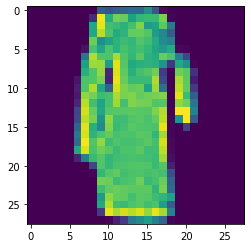

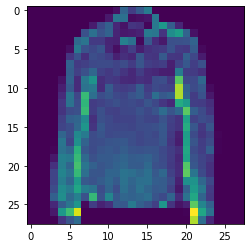

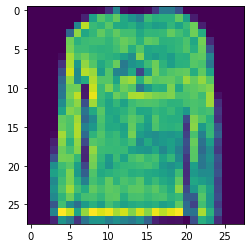

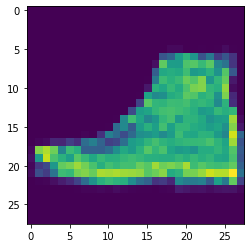

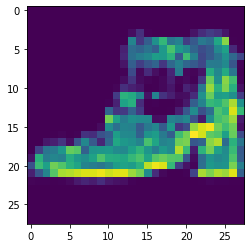

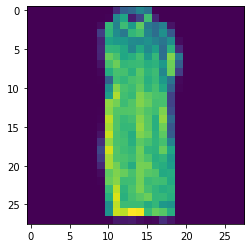

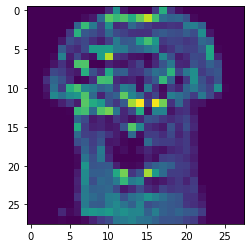

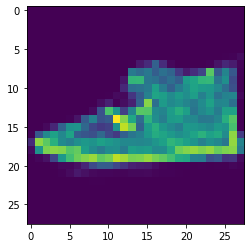

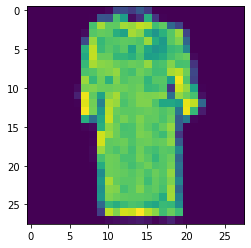

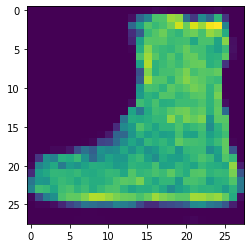

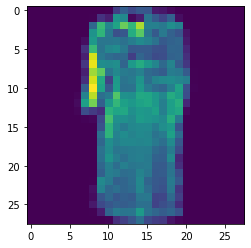

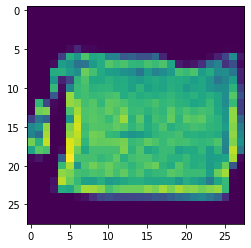

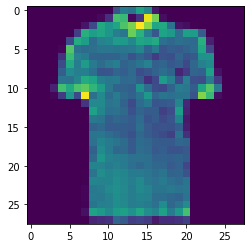

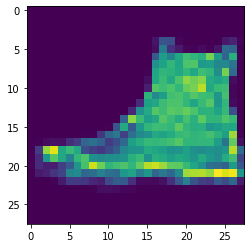

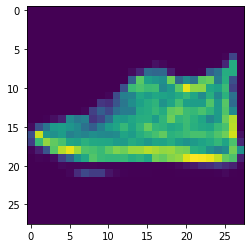

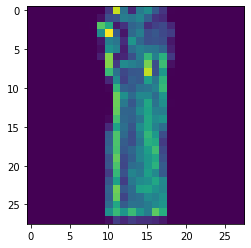

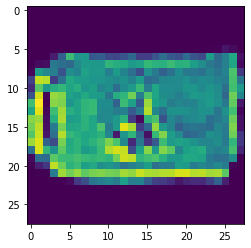

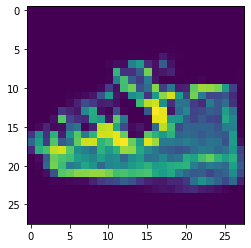

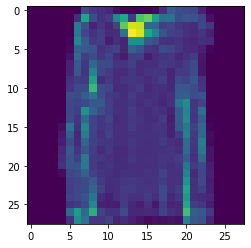

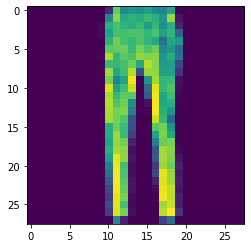

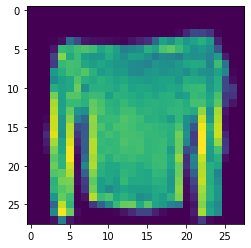

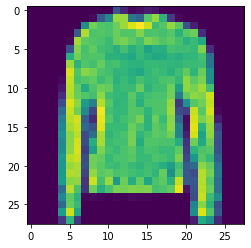

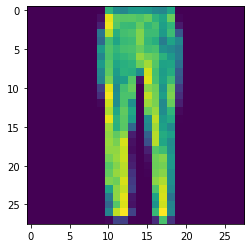

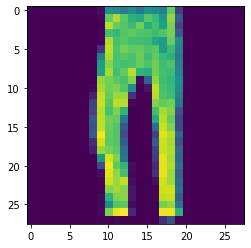

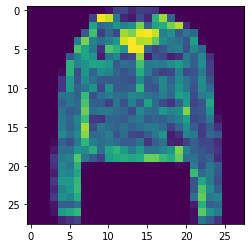

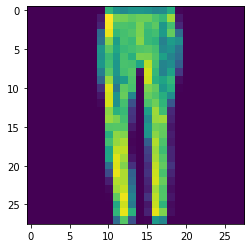

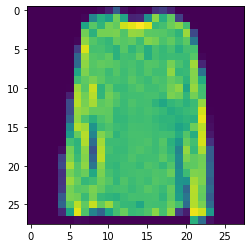

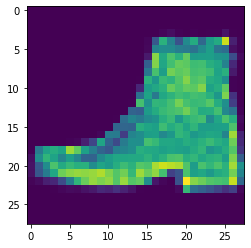

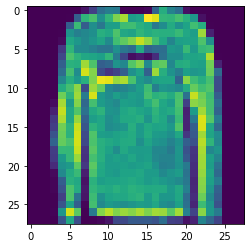

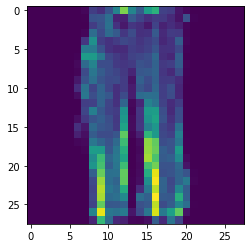

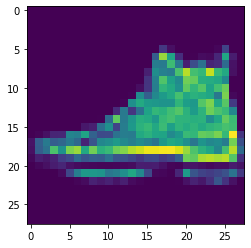

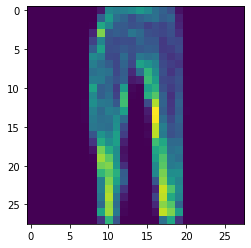

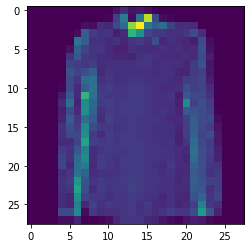

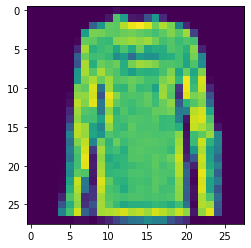

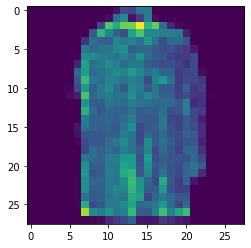

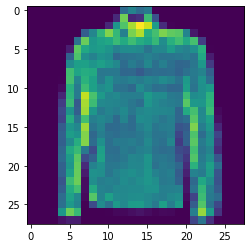

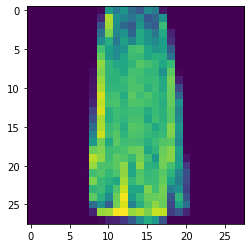

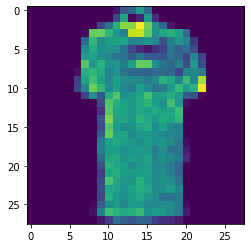

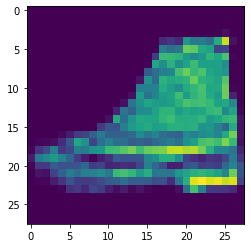

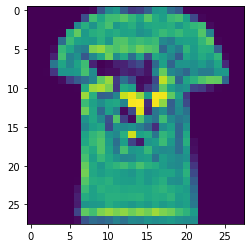

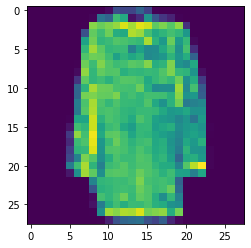

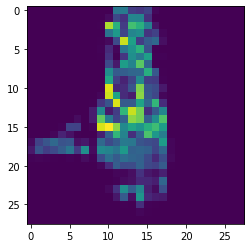

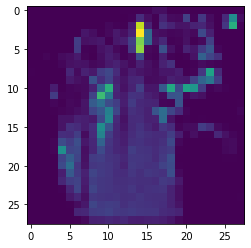

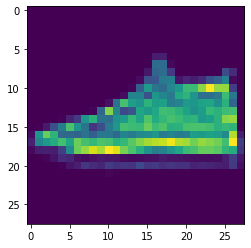

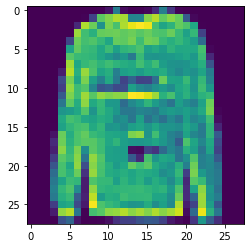

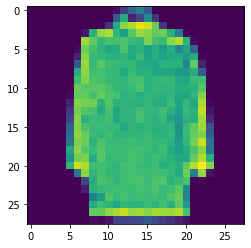

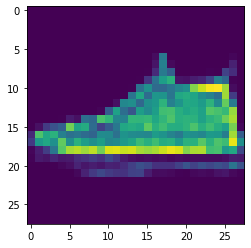

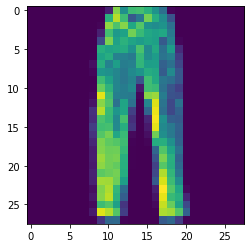

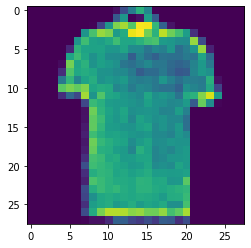

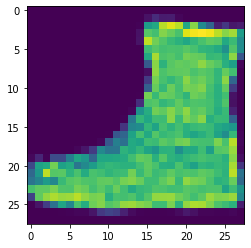

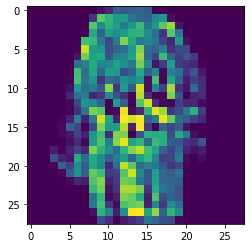

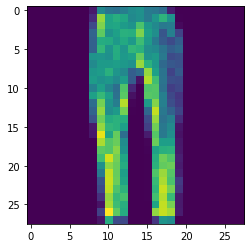

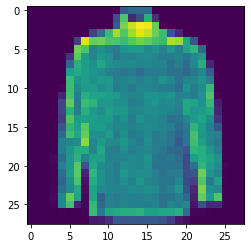

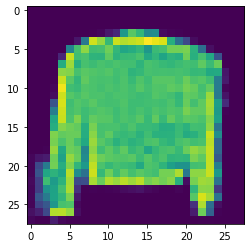

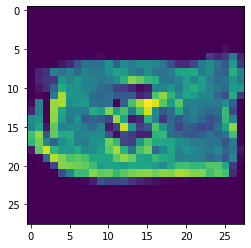

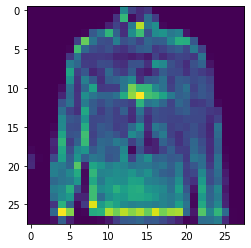

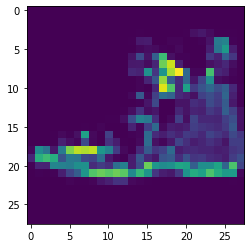

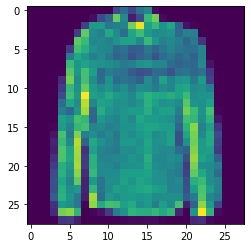

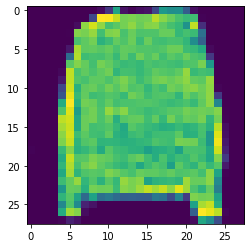

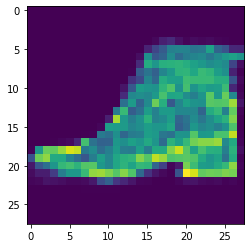

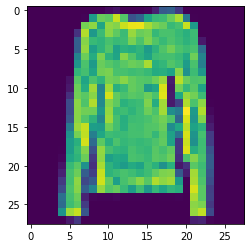

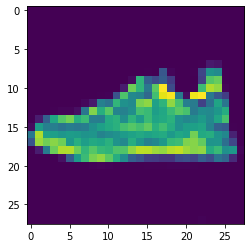

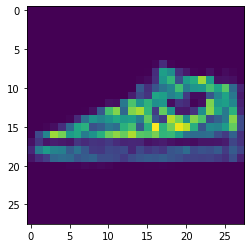

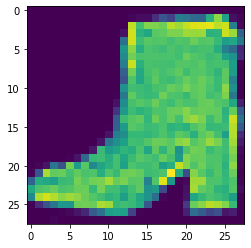

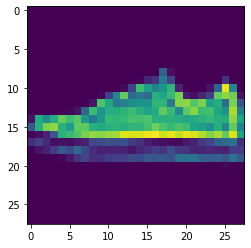

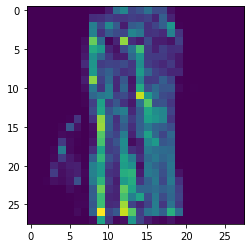

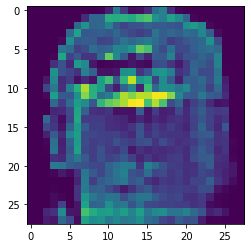

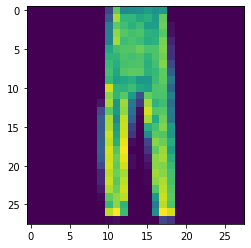

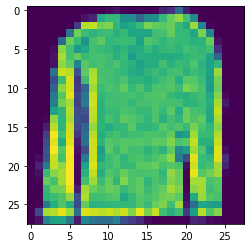

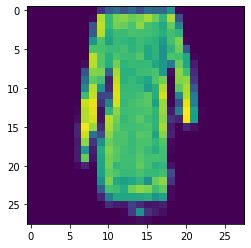

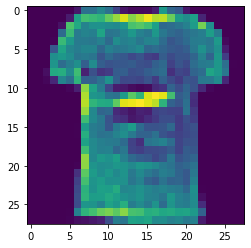

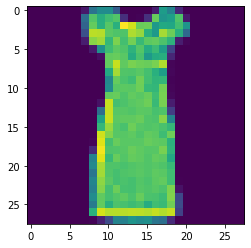

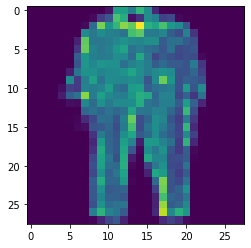

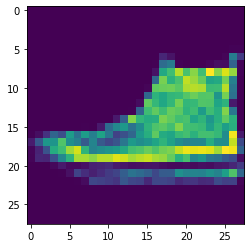

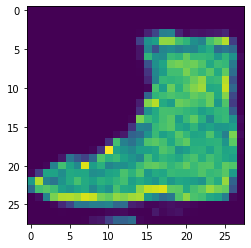

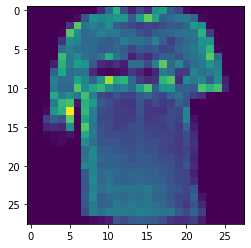

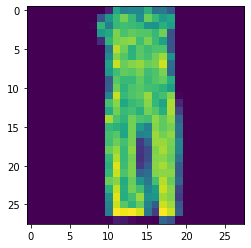

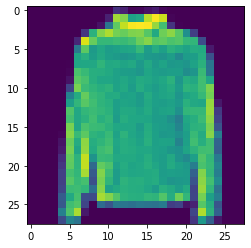

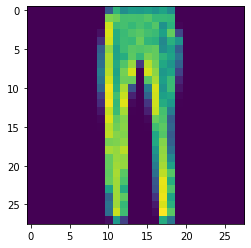

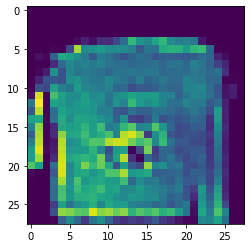

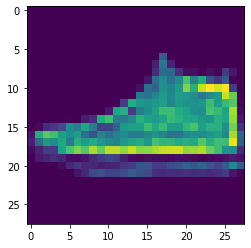

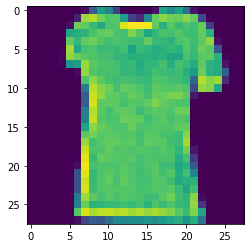

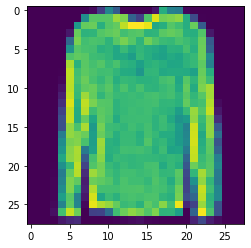

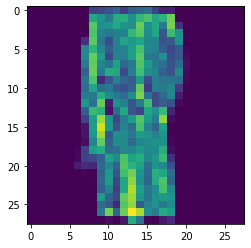

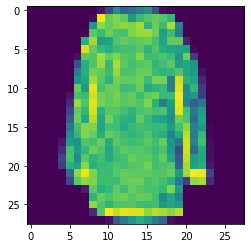

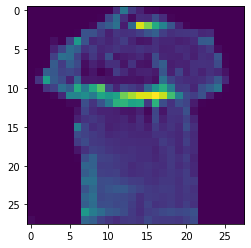

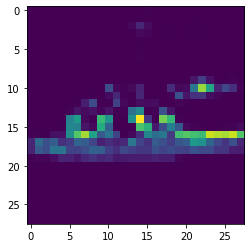

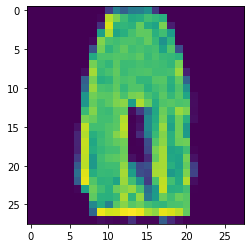

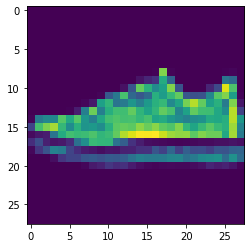

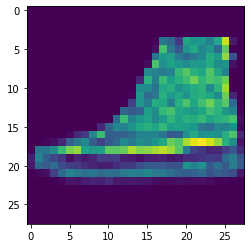

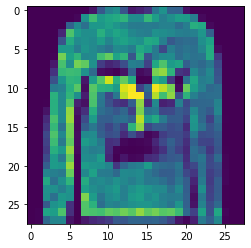

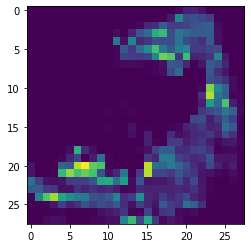

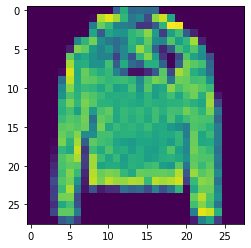

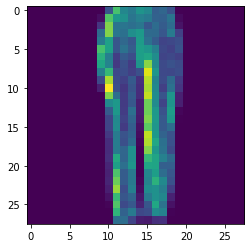

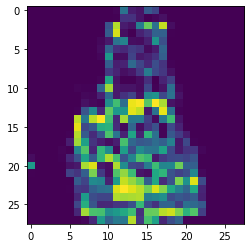

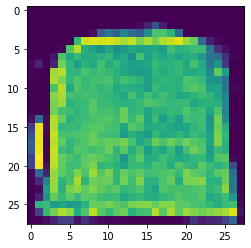

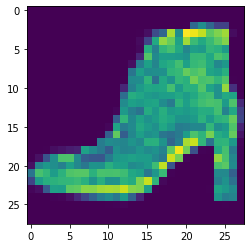

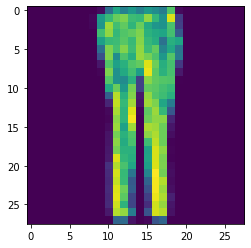

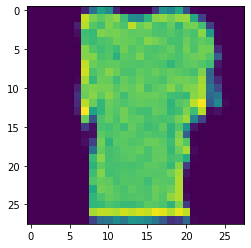

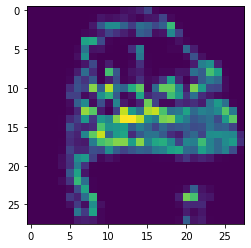

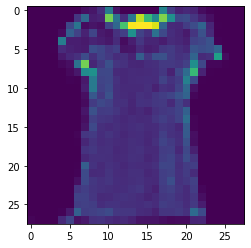

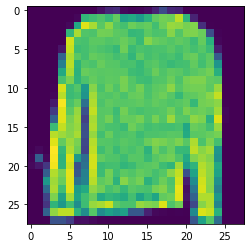

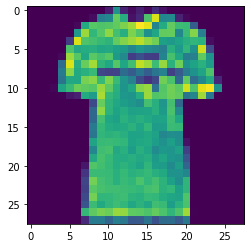

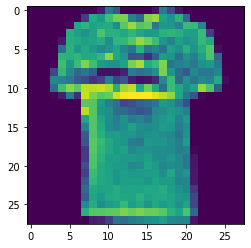

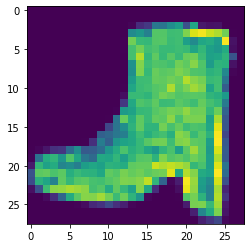

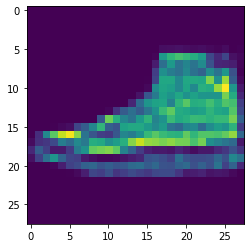

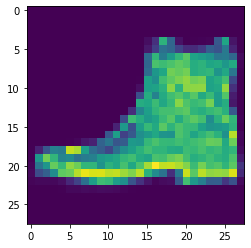

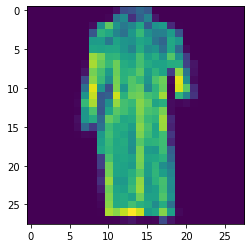

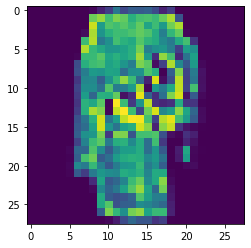

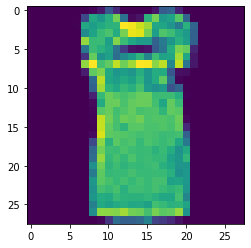

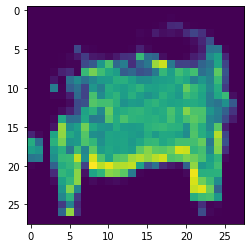

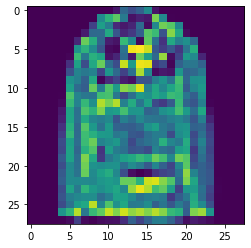

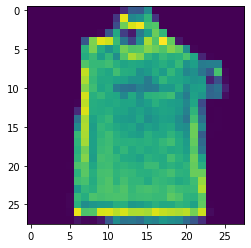

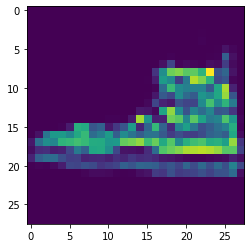

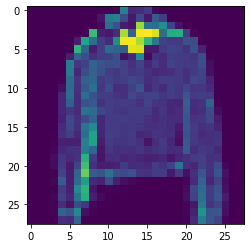

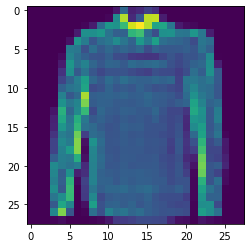

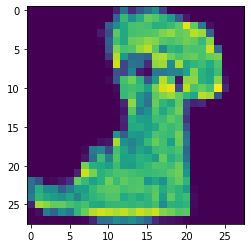

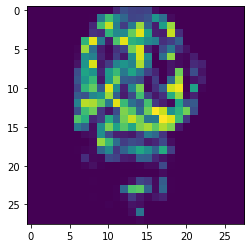

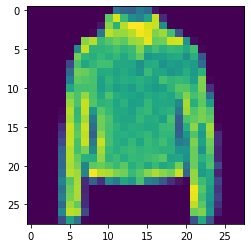

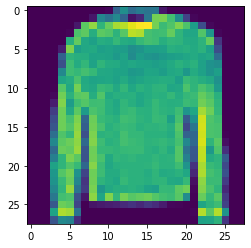

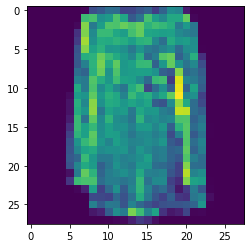

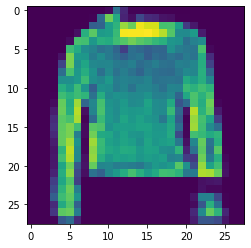

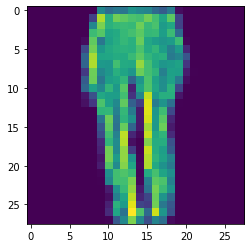

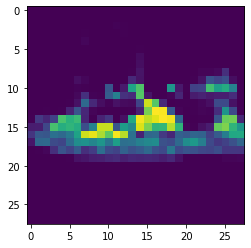

In [28]:
latent_vector = np.random.normal(size = (124,gan.latent_dim))
generated_ims = gan.generator(latent_vector)
for i in range(124):
  plt.imshow(np.squeeze(generated_ims[i]))
  plt.show()

In [29]:
gan.generator.save('gen.h')
gan.discriminator.save('disc.h')

INFO:tensorflow:Assets written to: gen.h/assets


INFO:tensorflow:Assets written to: gen.h/assets


INFO:tensorflow:Assets written to: disc.h/assets


INFO:tensorflow:Assets written to: disc.h/assets
